# Experimental data pre-processing

## Import modules, load data

In [2]:
# Imports
import pickle
import os

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from utils import rot_quat_utilsv2
from utils import remap_utilsv2 as remap

In [3]:
# Loading the entire dataset (~2GB of memory loaded)
try:
    data
except NameError:
    data = pd.read_csv('./data/corpus_ProxyDistal_RightHanded_Train.csv')

In [4]:
# Print all columns
print("\n".join([" ".join(list(data.columns)[i:i+5]) for i in range(0, len(data.columns), 5)]))

Unnamed: 0 subjectId timestamp tgtNumber tgtType
tgtRed objCatched expeInPause nbTgtsValidated nbTgtsSkipped
tgtPos_x tgtPos_y tgtPos_z tgtQuat_x tgtQuat_y
tgtQuat_z tgtQuat_w refInitPos_x refInitPos_y refInitPos_z
refInitQuat_x refInitQuat_y refInitQuat_z refInitQuat_w refArmPos_x
refArmPos_y refArmPos_z refArmQuat_x refArmQuat_y refArmQuat_z
refArmQuat_w shouVirtPos_x shouVirtPos_y shouVirtPos_z shouCustPos_x
shouCustPos_y shouCustPos_z shouVirtQuatRaw_x shouVirtQuatRaw_y shouVirtQuatRaw_z
shouVirtQuatRaw_w shouCustQuatRaw_x shouCustQuatRaw_y shouCustQuatRaw_z shouCustQuatRaw_w
shouVirtQuat_x shouVirtQuat_y shouVirtQuat_z shouVirtQuat_w shouCustQuat_x
shouCustQuat_y shouCustQuat_z shouCustQuat_w elbVirtPos_x elbVirtPos_y
elbVirtPos_z elbCustPos_x elbCustPos_y elbCustPos_z elbVirtQuat_x
elbVirtQuat_y elbVirtQuat_z elbVirtQuat_w elbCustQuat_x elbCustQuat_y
elbCustQuat_z elbCustQuat_w wriVirtPos_x wriVirtPos_y wriVirtPos_z
wriCustPos_x wriCustPos_y wriCustPos_z wriVirtQuat_x wriVirtQuat

In [5]:
len(pd.unique(data["subjectId"]))
tgtPerSubject = [len(pd.unique(subject_data["tgtNumber"])) for subject, subject_data in data.groupby("subjectId")]

In [6]:
np.mean(tgtPerSubject), (np.max(tgtPerSubject)-np.min(tgtPerSubject))/2

(253.23529411764707, 42.5)

In [7]:
durations = [len(seq[1])/90 for seq in data.groupby("tgtNumber")]

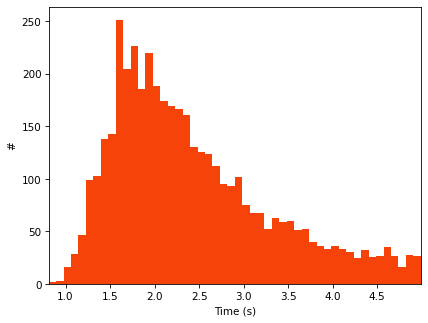

In [8]:
plt.figure()
plt.hist(durations, bins=50)
plt.xlabel("Time (s)")
plt.ylabel("#")
plt.show()

## Changing frame of reference and conversions

### From sensor's quaternions to joint angles (the *configuration*)

The arm is the angle frame of reference here

In [9]:
config_np = rot_quat_utilsv2.quats2config(
    quats_upper = np.array(data.loc[:, 'shouVirtQuat_x':'shouVirtQuat_w']),
    quats_fore  = np.array(data.loc[:, 'elbVirtQuat_x':'elbVirtQuat_w']),
    quats_hand  = np.array(data.loc[:, 'wriVirtQuat_x':'wriVirtQuat_w']),

    quats_ref   = np.array(data.loc[:, 'refArmQuat_x':'refArmQuat_w']),
    unit='rad',
)

config = pd.DataFrame(config_np, columns=[
    'shoulderPitch',
    'shoulderRoll',
    'armYaw',
    'elbowPitch',
    'forearmYaw',
    'wristPitch',
    'wristRoll',
])

config.head()

,shoulderPitch,shoulderRoll,armYaw,elbowPitch,forearmYaw,wristPitch,wristRoll
0,-0.250241,-0.242430,0.464143,-1.123859,0.666852,-0.189206,-0.295755
1,-0.233530,-0.244799,0.461430,-1.123318,0.666487,-0.188775,-0.295574
2,-0.233477,-0.244344,0.460844,-1.123209,0.667164,-0.188337,-0.295380
3,-0.232215,-0.243392,0.459582,-1.123186,0.667112,-0.187481,-0.295304
4,-0.232894,-0.243632,0.459685,-1.123147,0.667522,-0.187184,-0.294928


In [10]:
pd.unique(data["subjectId"])

array([10, 11, 13, 14,  3,  5,  6,  7,  8,  9, 27, 28, 29, 30, 31, 32, 33])

### Position remapping

All subjects doesn't have the same arm length. In order to have an homogeneous dataset to train on, we virtually normalize the environment so that the task is equivalent.

The position of the end effector is induced by the arm's configuration

In [11]:
arm_dimensions = np.array([
    [0, -0.28, 0], # position of elbow in the shoulder frame of ref
    [0, -0.25, 0], # position of wrist in the elbow frame of ref
    [0, 0, 0], # Position of the end effector in the wrist frame of reference
])

try:
    endEffPos
except NameError:
    (endEffPos, endEffRot, arrowVecs) = remap.get_remapped_block(
        config,
        arm_dimensions,
        arrow_offset=None,
        urdf_path="",
    )

endEffPos.shape

/home/paul/anaconda3/envs/cobiopro/lib/python3.10/site-packages/ikpy/chain.py:60: UserWarning: Link Base link (index: 0) is of type 'fixed' but set as active in the active_links_mask. In practice, this fixed link doesn't provide any transformation so is as it were inactive
  warnings.warn("Link {} (index: {}) is of type 'fixed' but set as active in the active_links_mask. In practice, this fixed link doesn't provide any transformation so is as it were inactive".format(link.name, link_index))


(939925, 3)

#### Fix Pitch

Pitch values are split between ~$-\pi$ and ~$\pi$

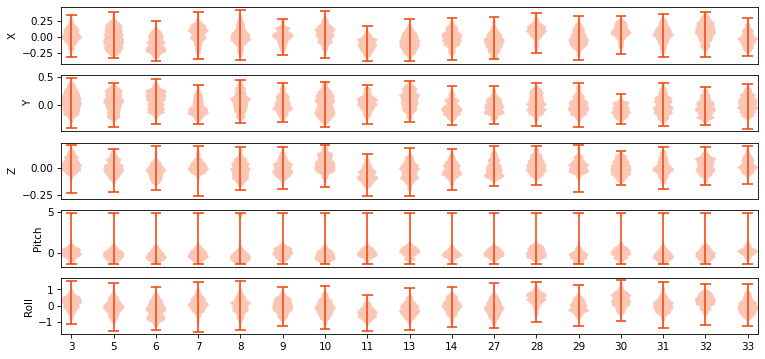

In [12]:
subject_id = [str(sub[0]) for sub in data.groupby("subjectId")]

remapped = pd.concat((
    data["subjectId"], 
    pd.DataFrame(endEffPos, columns=["X", "Y", "Z"]), 
    pd.DataFrame(endEffRot[:, :2], columns=["Pitch", "Roll"])
), axis=1)
subject_remapped = [sub[1] for sub in remapped.groupby("subjectId")]

plt.figure(figsize=(12, 8))
axes = ["X", "Y", "Z", "Pitch", "Roll",]

for i, axis in enumerate(axes):
    plt.subplot(7,1,i+1)
    mean = remapped[axis].mean()
    plt.violinplot([sub[axis]-mean for sub in subject_remapped])
    plt.xticks([])
    plt.ylabel(axis)
plt.xticks(list(range(1, len(subject_id)+1)), subject_id)
plt.show()

In [13]:
endEffRot[:, 0] = (endEffRot[:, 0]+2*np.pi-1)%(2*np.pi)

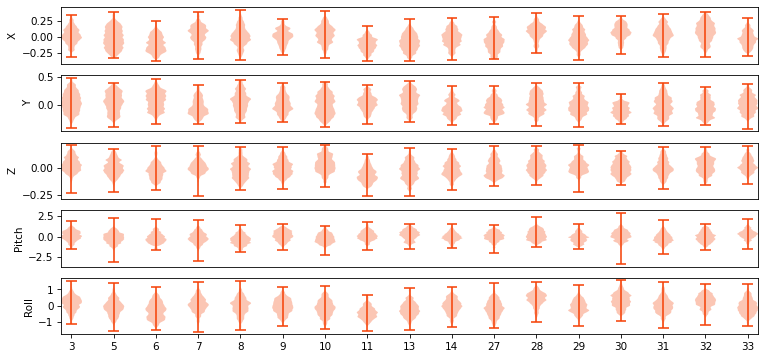

In [14]:
remapped = pd.concat((
    data["subjectId"], 
    pd.DataFrame(endEffPos, columns=["X", "Y", "Z"]), 
    pd.DataFrame(endEffRot[:, :2], columns=["Pitch", "Roll"])
), axis=1)
subject_remapped = [sub[1] for sub in remapped.groupby("subjectId")]

plt.figure(figsize=(12, 8))
axes = ["X", "Y", "Z", "Pitch", "Roll",]

for i, axis in enumerate(axes):
    plt.subplot(7,1,i+1)
    mean = remapped[axis].mean()
    plt.violinplot([sub[axis]-mean for sub in subject_remapped])
    plt.xticks([])
    plt.ylabel(axis)
plt.xticks(list(range(1, len(subject_id)+1)), subject_id)
plt.show()

#### Target redefinition

The target state (position + orientation) is the end effector state on the last timestep. This is in order to take into account the remapping.

Another possibility is to make a linear regression of tgt / endEff

In [15]:
# indices of the last timestep of every target series

tgt_groups = data.groupby("tgtNumber")
# tgtNumber -> last index dict
tgtToLastIndex = {tgtNumber: series.index[-1] for tgtNumber, series in tgt_groups}
# pd.Series timestep -> last timestep of current target
indices = data["tgtNumber"].copy().replace(tgtToLastIndex)
tgtPos_remap = endEffPos[indices, :]
tgtRot_remap = endEffRot[indices, :2]

### Deleting and concatenating columns

Deleting useless columns that aren't useful anymore, and fusing columns of interest.

In [16]:
new_data = pd.concat([
    data[["timestamp", "subjectId", "tgtNumber", "tgtRed"]],
    config, # shoulderPitch, shoulderRoll, armYaw, elbowPitch, forearmYaw, wristPitch, wristRoll
    pd.DataFrame(endEffPos, columns=["endEffX", "endEffY", "endEffZ"]),
    pd.DataFrame(endEffRot[:, 0:2], columns=["endEffPitch", "endEffRoll"]),
    pd.DataFrame(tgtPos_remap, columns=["tgtX", "tgtY", "tgtZ"]),
    pd.DataFrame(tgtRot_remap, columns=["tgtPitch", "tgtRoll"])
], axis='columns')

new_data.head()

,timestamp,subjectId,tgtNumber,tgtRed,shoulderPitch,shoulderRoll,armYaw,elbowPitch,forearmYaw,wristPitch,...,endEffX,endEffY,endEffZ,endEffPitch,endEffRoll,tgtX,tgtY,tgtZ,tgtPitch,tgtRoll
0,0.021321,10,0,False,-0.250241,-0.242430,0.464143,-1.123859,0.666852,-0.189206,...,0.004814,-0.338522,0.294599,3.666127,0.303153,-0.041466,0.131686,0.367284,2.600889,-0.38316
1,0.032686,10,0,False,-0.233530,-0.244799,0.461430,-1.123318,0.666487,-0.188775,...,0.003278,-0.343336,0.289114,3.683677,0.299568,-0.041466,0.131686,0.367284,2.600889,-0.38316
2,0.043437,10,0,False,-0.233477,-0.244344,0.460844,-1.123209,0.667164,-0.188337,...,0.003335,-0.343332,0.289141,3.683934,0.299068,-0.041466,0.131686,0.367284,2.600889,-0.38316
3,0.055584,10,0,False,-0.232215,-0.243392,0.459582,-1.123186,0.667112,-0.187481,...,0.003467,-0.343610,0.288815,3.685103,0.297406,-0.041466,0.131686,0.367284,2.600889,-0.38316
4,0.065655,10,0,False,-0.232894,-0.243632,0.459685,-1.123147,0.667522,-0.187184,...,0.003387,-0.343431,0.289037,3.685055,0.297562,-0.041466,0.131686,0.367284,2.600889,-0.38316


### Remove subjects 30 and subject 7

Subject 30 has Pitch values that spans accross -pi and pi, so we remove it, we randomly remove subject 7 so that we have 15 subjects, which is better for train-test-split lol

In [17]:
new_data = new_data[new_data["subjectId"] != 7][new_data["subjectId"] != 30]

/tmp/ipykernel_34720/460737397.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  new_data = new_data[new_data["subjectId"] != 7][new_data["subjectId"] != 30]


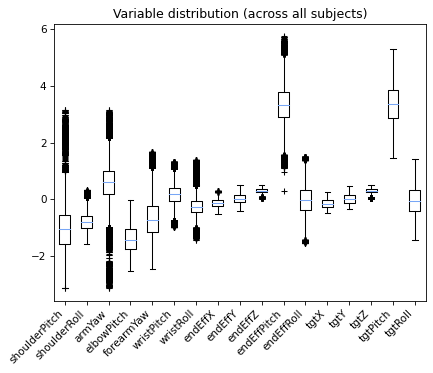

In [18]:
plt.figure()
to_plot = new_data.loc[:, "shoulderPitch":"tgtRoll"]
plt.boxplot(to_plot, sym="k+")
columns = to_plot.columns
plt.xticks(1+np.array(range(len(columns))), columns, rotation=45, ha="right")
plt.title("Variable distribution (across all subjects)")
plt.show()

/tmp/ipykernel_34720/1958462548.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(new_data["tgtX"][OFFSET:OFFSET+LENGTH], color="#080", linewidth=2, label="Target")
/tmp/ipykernel_34720/1958462548.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(new_data["endEffX"][OFFSET:OFFSET+LENGTH], color="#0F0", linewidth=1, label="End effector")
/tmp/ipykernel_34720/1958462548.py:13: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecat

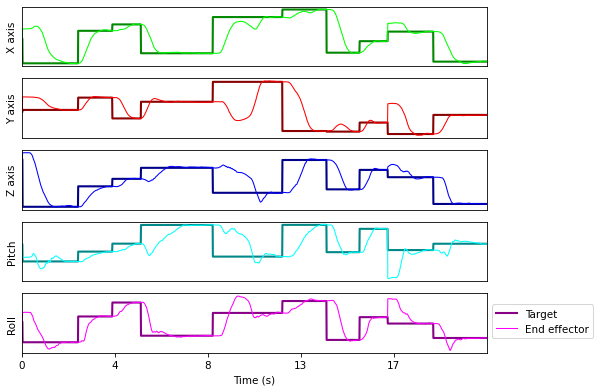

In [19]:
OFFSET = 134_019
LENGTH = 2000

plt.figure(figsize=(8, 6))

plt.subplot(5,1,1)
plt.plot(new_data["tgtX"][OFFSET:OFFSET+LENGTH], color="#080", linewidth=2, label="Target")
plt.plot(new_data["endEffX"][OFFSET:OFFSET+LENGTH], color="#0F0", linewidth=1, label="End effector")
plt.ylabel("X axis")
plt.xticks([]); plt.yticks([])

plt.subplot(5,1,2)
plt.plot(new_data["tgtY"][OFFSET:OFFSET+LENGTH], color="#800", linewidth=2, label="Target")
plt.plot(new_data["endEffY"][OFFSET:OFFSET+LENGTH], color="#F00", linewidth=1, label="End effector")
plt.ylabel("Y axis")
plt.xticks([]); plt.yticks([])

plt.subplot(5,1,3)
plt.plot(new_data["tgtZ"][OFFSET:OFFSET+LENGTH], color="#008", linewidth=2, label="Target")
plt.plot(new_data["endEffZ"][OFFSET:OFFSET+LENGTH], color="#00F", linewidth=1, label="End effector")
plt.ylabel("Z axis")
plt.xticks([]); plt.yticks([])

plt.subplot(5,1,4)
plt.plot(new_data["tgtPitch"][OFFSET:OFFSET+LENGTH], color="#088", linewidth=2, label="Target")
plt.plot(new_data["endEffPitch"][OFFSET:OFFSET+LENGTH], color="#0FF", linewidth=1, label="End effector")
plt.ylabel("Pitch")
plt.xticks([]); plt.yticks([])

plt.subplot(5,1,5)
plt.plot(new_data["tgtRoll"][OFFSET:OFFSET+LENGTH], color="#808", linewidth=2, label="Target")
plt.plot(new_data["endEffRoll"][OFFSET:OFFSET+LENGTH], color="#F0F", linewidth=1, label="End effector")
plt.ylabel("Roll"); plt.xlabel("Time")
plt.yticks([])
plt.xticks(np.arange(OFFSET, OFFSET+LENGTH, LENGTH / 5), np.arange(0, LENGTH, LENGTH / 5, dtype=int) // 90)


plt.xlabel("Time (s)")
plt.legend(loc="upper left", bbox_to_anchor=(1., 0.9))
plt.savefig("dataset_sample.svg")
plt.show()

## Subject separation

In [20]:
subject_data = {s:d for s,d in new_data.groupby("subjectId")}

### Min-max normalization

Rescale everything between -1 and 1

In [21]:
def normalize(df):
    """
    Min-max-normalize the dataframe inplace.
    min -> -1 ; max -> +1;
    Returns the min and the max values for each column.
    """
    extrema = {}
    normalized = df.copy()
    for column in df.loc[:, "shoulderPitch":"tgtRoll"].columns:
        c_min = df[column].min()
        c_max = df[column].max()
        normalized[column] = 2 * (df[column] - c_min) / (c_max - c_min) - 1
        extrema[column] = (c_min, c_max)

    return normalized, extrema
    

In [23]:
normalized_data = {s : normalize(subject_data[s])[0] for s in subject_data}
extrema = {s : normalize(subject_data[s])[1] for s in subject_data}

with open("./data/global_normalization_values2.pickle", "wb+") as file:
    pickle.dump(extrema, file)

extrema

{3: {'shoulderPitch': (-3.096078014596476, 0.26050197547188764),
  'shoulderRoll': (-1.4878853626131276, -0.015212295802521147),
  'armYaw': (-0.3943350509762438, 2.521865708224247),
  'elbowPitch': (-2.075729190853222, -0.2813429546696675),
  'forearmYaw': (-2.4424130045517165, 0.8079464966433938),
  'wristPitch': (-0.7261013355927329, 1.2701144072184989),
  'wristRoll': (-0.8541071859924247, 1.3226762810190413),
  'endEffX': (-0.44287456475469555, 0.2038735044512236),
  'endEffY': (-0.40841292982801874, 0.5025712374546347),
  'endEffZ': (0.07071141741030278, 0.5056333554808722),
  'endEffPitch': (1.8703544072962188, 5.273997430928613),
  'endEffRoll': (-1.086508743302241, 1.4938984039121395),
  'tgtX': (-0.4392173364017391, 0.191633925014864),
  'tgtY': (-0.3001832127469015, 0.468357406260424),
  'tgtZ': (0.16980625102936836, 0.5004058317630717),
  'tgtPitch': (1.8943731348172754, 5.154921408754429),
  'tgtRoll': (-1.0717115022004104, 1.4047274629170703)},
 5: {'shoulderPitch': (-3.0

In [24]:
import pickle

with open("./data/global_normalization_values2.pickle", "rb") as file:
    subject_extrema = pickle.load(file)

subject_extrema

{3: {'shoulderPitch': (-3.096078014596476, 0.26050197547188764),
  'shoulderRoll': (-1.4878853626131276, -0.015212295802521147),
  'armYaw': (-0.3943350509762438, 2.521865708224247),
  'elbowPitch': (-2.075729190853222, -0.2813429546696675),
  'forearmYaw': (-2.4424130045517165, 0.8079464966433938),
  'wristPitch': (-0.7261013355927329, 1.2701144072184989),
  'wristRoll': (-0.8541071859924247, 1.3226762810190413),
  'endEffX': (-0.44287456475469555, 0.2038735044512236),
  'endEffY': (-0.40841292982801874, 0.5025712374546347),
  'endEffZ': (0.07071141741030278, 0.5056333554808722),
  'endEffPitch': (1.8703544072962188, 5.273997430928613),
  'endEffRoll': (-1.086508743302241, 1.4938984039121395),
  'tgtX': (-0.4392173364017391, 0.191633925014864),
  'tgtY': (-0.3001832127469015, 0.468357406260424),
  'tgtZ': (0.16980625102936836, 0.5004058317630717),
  'tgtPitch': (1.8943731348172754, 5.154921408754429),
  'tgtRoll': (-1.0717115022004104, 1.4047274629170703)},
 5: {'shoulderPitch': (-3.0

In [25]:
# normalized_data["shoulderPitch"].min(), normalized_data["shoulderPitch"].max()

In [26]:
# plt.figure()
# to_plot = normalized_data.loc[:, "shoulderPitch":"tgtRoll"]
# plt.boxplot(to_plot, sym="k+")
# columns = to_plot.columns
# plt.xticks(1+np.array(range(len(columns))), columns, rotation=45)
# plt.show()

## *Enregistrement du dataset*

In [27]:
# Enregistrement du dataset pré-traité

# if (not os.path.exists('../raw_data/preprocessed.pickle')):
with open('./data/preprocessed_subjectwise_.pickle', 'wb+') as file:
    pickle.dump(normalized_data, file)

print(f"File size : {os.path.getsize('./data/preprocessed_subjectwise_.pickle') / 1e6:.1f} Mo")

File size : 141.2 Mo
